<a href="https://colab.research.google.com/github/geral108/SEMANA3/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Paso 1: Importar librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, os

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau


In [15]:
# Paso 2: Descargar data histórica
ticker = "AAPL"  # cámbialo por tu cripto si quieres (ej: "BTC-USD")
data = yf.download(ticker, period="max", auto_adjust=True)

# Aplanar columnas si vienen en MultiIndex tipo (Close, AAPL)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [c[0] for c in data.columns]

# Asegurarnos del orden de columnas
cols = ['Close','High','Low','Open','Volume']
data = data[cols]

print("Columnas:", list(data.columns))
print(data.head(), "\n", data.tail())


[*********************100%***********************]  1 of 1 completed

Columnas: ['Close', 'High', 'Low', 'Open', 'Volume']
               Close      High       Low      Open     Volume
Date                                                         
1980-12-12  0.098485  0.098913  0.098485  0.098485  469033600
1980-12-15  0.093347  0.093775  0.093347  0.093775  175884800
1980-12-16  0.086495  0.086924  0.086495  0.086924  105728000
1980-12-17  0.088636  0.089064  0.088636  0.088636   86441600
1980-12-18  0.091206  0.091634  0.091206  0.091206   73449600 
                  Close        High         Low        Open    Volume
Date                                                                
2025-08-13  233.330002  235.000000  230.429993  231.070007  69878500
2025-08-14  232.779999  235.119995  230.850006  234.059998  51916300
2025-08-15  231.589996  234.279999  229.339996  234.000000  56038700
2025-08-18  230.889999  233.119995  230.110001  231.699997  37476200
2025-08-19  230.559998  232.869995  229.350006  231.279999  39320800


In [16]:
# Paso 3: Normalización y separación train/test
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(data),
    columns=data.columns,
    index=data.index
)

# Últimos 90 días para test
hoy = datetime.datetime.today().date()
fecha_limite = hoy - datetime.timedelta(days=90)

train_df = data_scaled[data_scaled.index < pd.to_datetime(fecha_limite)]
test_df  = data_scaled[data_scaled.index >= pd.to_datetime(fecha_limite)]

print(f"Filas train: {len(train_df)}  |  Filas test: {len(test_df)}")

# Crear secuencias
sequence_length = 60
target_col = 'Close'
target_idx = data.columns.get_loc(target_col)

def create_sequences(mat, seq_len, target_col_idx):
    X, y = [], []
    for i in range(seq_len, len(mat)):
        X.append(mat[i-seq_len:i])
        y.append(mat[i, target_col_idx])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_df.values, sequence_length, target_idx)
X_test,  y_test  = create_sequences(test_df.values,  sequence_length, target_idx)

print("Shapes ->",
      "X_train:", X_train.shape, "y_train:", y_train.shape,
      "| X_test:", X_test.shape, "y_test:", y_test.shape)


Filas train: 11201  |  Filas test: 61
Shapes -> X_train: (11141, 60, 5) y_train: (11141,) | X_test: (1, 60, 5) y_test: (1,)


In [17]:
# Paso 4: Definir el modelo Transformer
def build_transformer_model(input_shape, num_heads=4, ff_dim=128, num_layers=2, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)

    for _ in range(num_layers):
        attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
            layers.Dropout(dropout_rate),
            layers.Dense(input_shape[-1])
        ])
        x = layers.Add()([x, ffn(x)])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs)

n_features = train_df.shape[1]
model = build_transformer_model(input_shape=(sequence_length, n_features))
model.summary()

# Compilar
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 5)     │         10 │ input_layer_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 5)     │     11,781 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 60, 5)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 5)     │         10 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 60, 5)     │      1,413 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 60, 5)     │          0 │ layer_normalizat… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 5)     │         10 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 60, 5)     │     11,781 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 60, 5)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 5)     │         10 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 60, 5)     │      1,413 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 60, 5)     │          0 │ layer_normalizat… │
│                     │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 60, 5)     │         10 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 5)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │        768 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 35,527 (138.78 KB)

 Trainable params: 35,527 (138.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
349/349 ━━━━━━━━━━━━━━━━━━━━ 64s 161ms/step - loss: 0.0454 - mae: 0.1312 - val_loss: 0.3004 - val_mae: 0.5382 - learning_rate: 1.0000e-04
Epoch 2/200
349/349 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - loss: 0.0318 - mae: 0.0875 - val_loss: 0.3701 - val_mae: 0.6000 - learning_rate: 1.0000e-04
Epoch 3/200
349/349 ━━━━━━━━━━━━━━━━━━━━ 81s 147ms/step - loss: 0.0292 - mae: 0.0788 - val_loss: 0.2703 - val_mae: 0.5107 - learning_rate: 1.0000e-04
Epoch 4/200
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - loss: 0.0276 - mae: 0.0732 - val_loss: 0.2499 - val_mae: 0.4907 - learning_rate: 1.0000e-04
Epoch 5/200
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - loss: 0.0262 - mae: 0.0690 - val_loss: 0.3222 - val_mae: 0.5600 - learning_rate: 1.0000e-04
Epoch 6/200
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - loss: 0.0262 - mae: 0.0675 - val_loss: 0.2930 - val_mae: 0.5336 - learning_rate: 1.0000e-04
Epoch 7/200
349/349 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - loss: 0.0254 - mae: 0.0661 - val_loss: 0.3

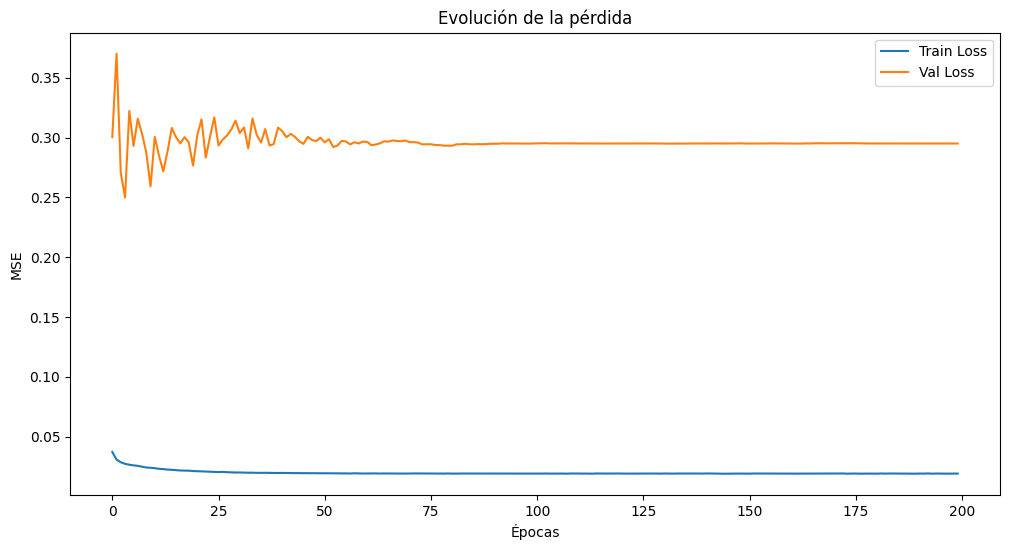

In [18]:
# Paso 5: Entrenamiento
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test) if len(X_test) > 0 else None,
    epochs=200,
    batch_size=32,
    callbacks=[tensorboard_callback, lr_scheduler],
    verbose=1
)

# Curvas de pérdida
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas'); plt.ylabel('MSE'); plt.legend(); plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


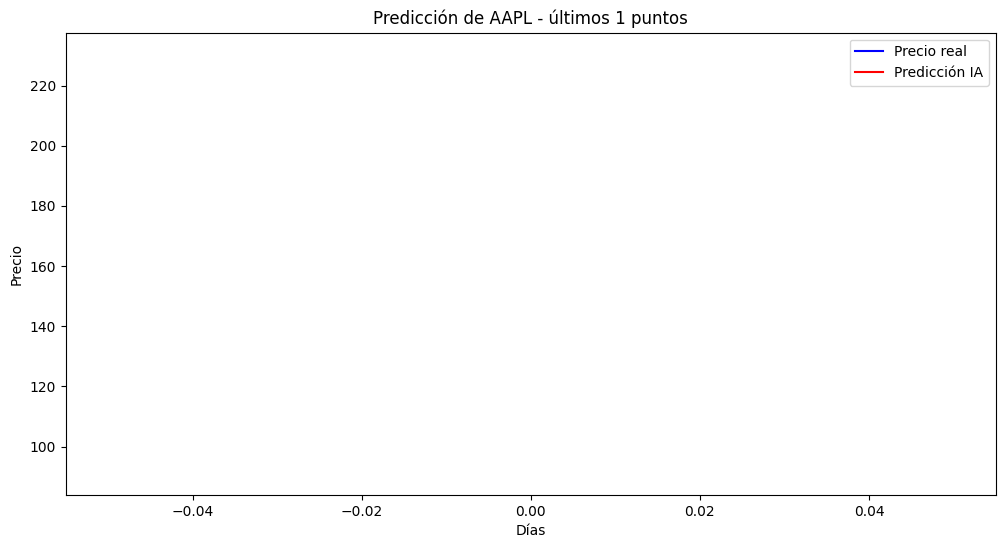

RMSE: 139.5532 | MAE: 139.5532


In [19]:
# Paso 6: Evaluación y gráficos
if len(X_test) == 0:
    print("No hay suficientes datos en test para crear secuencias (aumenta días de test).")
else:
    y_pred = model.predict(X_test)

    # Desnormalización correcta: colocar y en la columna 'Close'
    def invert_scaling(y_scaled):
        tmp = np.zeros((len(y_scaled), n_features))
        tmp[:, target_idx] = y_scaled.reshape(-1)
        return scaler.inverse_transform(tmp)[:, target_idx]

    y_test_real = invert_scaling(y_test)
    y_pred_real = invert_scaling(y_pred)

    # Gráfico
    plt.figure(figsize=(12,6))
    plt.plot(y_test_real, label='Precio real', color='blue')
    plt.plot(y_pred_real, label='Predicción IA', color='red')
    plt.title(f'Predicción de {ticker} - últimos {len(y_test_real)} puntos')
    plt.xlabel('Días'); plt.ylabel('Precio'); plt.legend(); plt.show()

    # Métricas
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    mae  = mean_absolute_error(y_test_real, y_pred_real)
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f}")
